# Autoencoders for unsupervised feature engineering
Hypothesis: Autoencoders may be used to augment the building of ML pipelines where labeled data is rare but unlabeled data is abundant.

Methodology:
1. Train linear classifier $C$ on small labeled dataset $d$ and evalulate performance.
1. Train autoencoder $A$ on $D$, train linear classifier $C''$ on $A(d)$, evaluate performance.

In [1]:
# %%

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import time
from tqdm.notebook import tqdm

SEED = 69
np.random.seed(SEED)
check_random_state(SEED)
torch.manual_seed(SEED)

X_tr = np.load('x_train.npy')
Y_tr = np.load('y_train.npy')
X_te = np.load('x_test.npy')
Y_te = np.load('y_test.npy')

In [2]:
# %%

# MNIST labels are randomly and evenly distributed. pixel intensities are scaled to [0,1]
D_IDX = 10_000

X_d = X_tr[:D_IDX]
Y_d = Y_tr[:D_IDX]

C = LogisticRegression(penalty=None)
C.fit(X_d, Y_d)
C_acc = accuracy_score(Y_te, C.predict(X_te))
print(f'C achieved {C_acc * 100}% accuracy on test set.')

C achieved 88.73% accuracy on test set.


c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
# %%

class Autoencoder_64(nn.Module):
    def __init__(self):
        super().__init__()
        # this is what "squishes"
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
        )
        
        # this is what "stretches"
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded =  self.decoder(encoded)
        return decoded
    
    # x is the numpy array, already flattened and normalized
    def fit(self, x, epochs=10, learning_rate=0.001, verbose=True):
        self.train()
        loader = DataLoader(torch.from_numpy(x).float(), batch_size=64, shuffle=True)
        adam = optim.Adam(self.parameters(), lr=learning_rate)
        crit = nn.MSELoss()
        train_start = time.time()
        for epoch in tqdm(range(epochs)):
            ep_start = time.time()
            ep_loss = 0.0
            for x in loader:
                adam.zero_grad()
                reconstructed = self(x)
                loss = crit(x, reconstructed)
                loss.backward()
                adam.step()
                ep_loss += loss.item()
            ep_end = time.time()
            if verbose:
                print(f'Epoch {epoch + 1}/{epochs}: Loss = {ep_loss/len(loader):.2f} in {ep_end - ep_start:.2f}s')
        train_end = time.time()
        if verbose:
            train_mins = int((train_end - train_start) // 60)
            train_secs = int((train_end - train_start) % 60)
            fname = 'ae_64_D.pth'
            print(f'Finished training in {train_mins}:{train_secs}.')
            print(f'Saving as {fname}.')
        torch.save(self, fname)
        return self

    # takes in and outputs numpy
    def transform(self, x):
        self.eval()
        with torch.no_grad():
            out = self.encoder(torch.from_numpy(x).float()).numpy()
        return out
    
    def fit_transform(self, x, epochs=10, learning_rate=0.001, verbose=True):
        self.fit(x, epochs=epochs, learning_rate=learning_rate, verbose=verbose)
        out = self.transform(x)
        return out
    
    def reconstruct(self, x):
        self.eval()
        with torch.no_grad():
            x_tensor = torch.from_numpy(x).float()
            out = self(x_tensor).numpy()
        return out

In [4]:
# %%

D = X_tr[D_IDX:]

In [5]:
# %%

from sklearn.decomposition import PCA
P = PCA(n_components=64)
P.fit(D)
P_X_d = P.transform(X_d)
Cprime = LogisticRegression(penalty=None)
Cprime.fit(P_X_d, Y_d)
P_X_te = P.transform(X_te)
Cprime_acc = accuracy_score(Y_te, Cprime.predict(P_X_te))

In [6]:
# %%

A = Autoencoder_64()
A.fit(D)
A_X_d = A.transform(X_d)
Cprimeprime = LogisticRegression(penalty=None)
Cprimeprime.fit(A_X_d, Y_d)
A_X_te = A.transform(X_te)
Cprimeprime_acc = accuracy_score(Y_te, Cprimeprime.predict(A_X_te))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Loss = 0.04 in 10.04s
Epoch 2/10: Loss = 0.02 in 9.37s
Epoch 3/10: Loss = 0.02 in 9.19s
Epoch 4/10: Loss = 0.01 in 8.78s
Epoch 5/10: Loss = 0.01 in 9.45s
Epoch 6/10: Loss = 0.01 in 10.19s
Epoch 7/10: Loss = 0.01 in 9.51s
Epoch 8/10: Loss = 0.01 in 11.35s
Epoch 9/10: Loss = 0.01 in 9.80s
Epoch 10/10: Loss = 0.01 in 9.97s
Finished training in 1:37.
Saving as ae_64_D.pth.


c:\Users\christian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
# %%

print(f'C achieved {C_acc * 100:.2f}% accuracy on test set.')
print(f'Cprime achieved {Cprime_acc * 100:.2f}% accuracy on test set.')
print(f'Cprimeprime achieved {Cprimeprime_acc * 100:.2f}% on test set.')

C achieved 88.73% accuracy on test set.
Cprime achieved 90.33% accuracy on test set.
Cprimeprime achieved 93.82% on test set.


Reject that $H_0$. Let's check that the autoencoder and PCA were learning useful information:

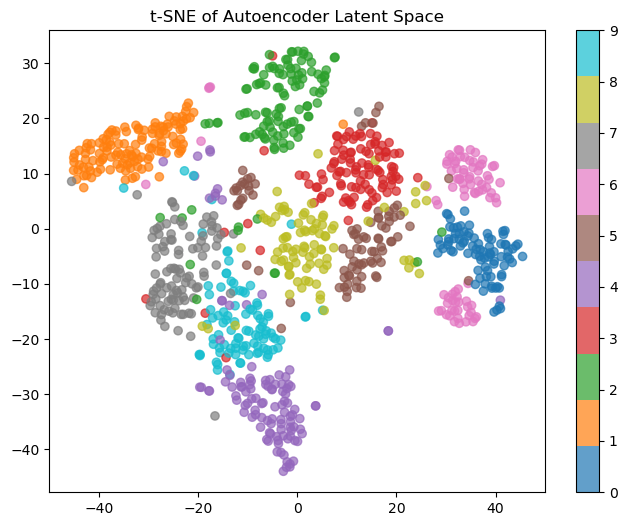

In [9]:
sample_X = X_te[:1000]
sample_Y = Y_te[:1000]
encoded = A.transform(sample_X)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=SEED)
embedded_2d = tsne.fit_transform(encoded)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], c=sample_Y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of Autoencoder Latent Space")
plt.show()

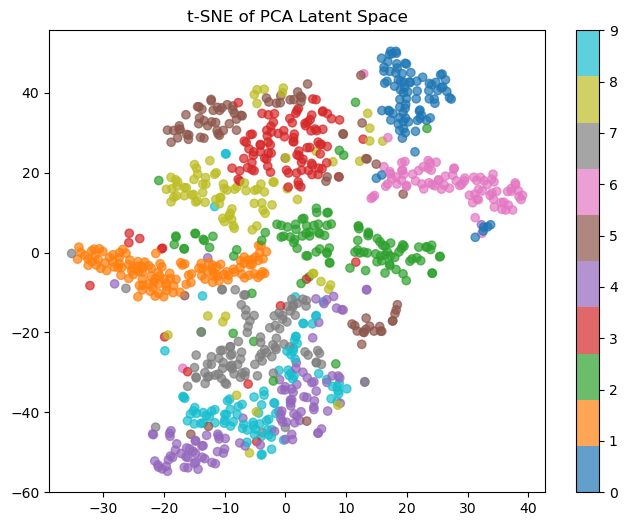

In [16]:
sample_X = X_te[:1000]
sample_Y = Y_te[:1000]
encoded = P.transform(sample_X)

tsne = TSNE(n_components=2, random_state=SEED)
embedded_2d = tsne.fit_transform(encoded)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], c=sample_Y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of PCA Latent Space")
plt.show()

And here's what you'll get if you try and see the clusters of the un-transformed data:

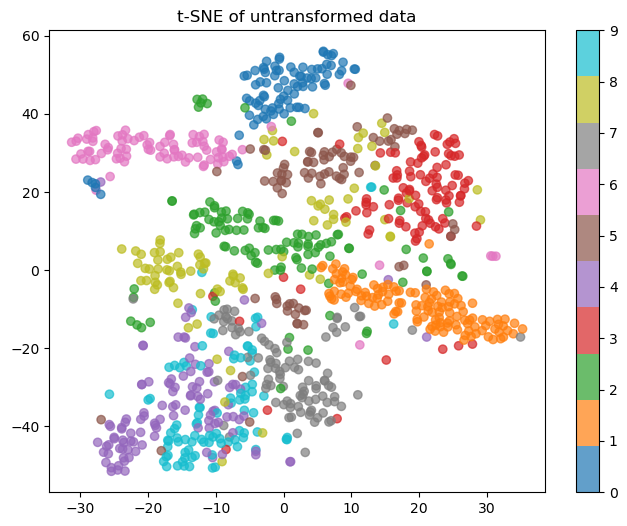

In [18]:
sample_X = X_te[:1000]
sample_Y = Y_te[:1000]

tsne = TSNE(n_components=2, random_state=SEED)
embedded_2d = tsne.fit_transform(sample_X)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], c=sample_Y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of untransformed data")
plt.show()